In [21]:
import os
import json
from pathlib import Path
import shutil
import random
import numpy as np

from datasets import load_dataset
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Loading pre-trained model:

In [5]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

model = VisionEncoderDecoderModel.from_pretrained("/home/harish3110/document-ai/data/models/donut-quandri-v1")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

### Building Inference Dataset

In [98]:
from pdf2image import convert_from_path
import glob

test_file_name = "test_5"
# Adding a page cut-off index to avoid processing large PDFs
cut_off_index = 5

# Set the PDF file path
inference_path = f'/home/harish3110/document-ai/data/inference/{test_file_name}/'
pdf_file_path = glob.glob(inference_path + '*.pdf')[0]
img_path = f"{inference_path}images"
os.makedirs(img_path, exist_ok=True)

# Convert PDF to a list of Pillow Image objects
images = convert_from_path(pdf_file_path)
# Save each image as a PNG file
for i, image in enumerate(images[:cut_off_index]):
    image.save(f'{img_path}/page_{i+1}.jpeg', 'JPEG')

In [99]:
# Load dataset
path = Path(img_path)
inference_dataset = load_dataset("imagefolder", data_dir=path, split="train")

Using custom data configuration default-12e799e852078481


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/harish3110/.cache/huggingface/datasets/imagefolder/default-12e799e852078481/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [100]:
print(f"Dataset has {len(inference_dataset)} images")

Dataset has 5 images


#### Processing the dataset for Donut

In [101]:
def preprocess_documents_for_donut_inference(sample):
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image}

In [102]:
inference_proc_dataset = inference_dataset.map(preprocess_documents_for_donut_inference)

  0%|          | 0/5 [00:00<?, ?ex/s]

In [103]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
# resizing the image to smaller sizes from [1920, 2560] to [720, 960]
processor.feature_extractor.size = [720, 960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/harish3110/mambaforge/lib/python3.9/site-packages/transformers/models/donut/processing_donut.py:186: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [104]:
def transform_and_tokenize_inference(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}
    return {"pixel_values": pixel_values}

inference_processed_dataset = inference_proc_dataset.map(transform_and_tokenize_inference, remove_columns=["image"])

  0%|          | 0/5 [00:00<?, ?ex/s]

### Running predictions on PDF:

In [105]:
def run_inference(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)
    return prediction

In [106]:
# Processing every image of PDF and storing them in a list
results = []

for index in tqdm(range(len(inference_processed_dataset))):
    prediction = run_inference(inference_processed_dataset[index])
    prediction['page_number'] = index + 1
    results.append(prediction)
    

100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


In [107]:
from collections import Counter

def majority_vote_dicts(dicts):
    combined_dict = {}
    for d in dicts:
        for k, v in d.items():
            if k in ['page_number', 'text_sequence']:
                continue
            if k not in combined_dict:
                combined_dict[k] = Counter()
            combined_dict[k][v] += 1
    result_dict = {}
    for k, v in combined_dict.items():
        result_dict[k] = v.most_common(1)[0][0]
    return result_dict

In [7]:
from collections import Counter
def majority_vote_dicts(dicts):
    combined_dict = {}
    for d in dicts:
        for k, v in d.items():
            if k in ['page_number', 'text_sequence']:
                continue
            if k not in combined_dict:
                combined_dict[k] = Counter()
            print(k)
            print(v)
            combined_dict[k][v] += 1
    result_dict = {}
    for k, v in combined_dict.items():
        result_dict[k] = v.most_common(1)[0][0]
    return result_dict

In [8]:
a = [{'insurance_carrier': 'intact INSURANCE', 'policy_number': '5 01359273 6795', 'effective_date': '30 Aug 2022', 'expiry_date': '30 Aug 2023', 'document_type': 'Business Insurance Statement', 'customer_name': 'MARRON BUSINESS PRODUCTS INC. O / A IDS - BEYOND TECHNOLOGY', 'customer_address': '647 WILTON GROVE UNIT 4 LONDON ON N6N 1N7', 'broker_name': 'REITH & ASSOCIATES INSURANCE & FINANCIAL SERVICES LTD', 'broker_address': '462 TALBOT STREET ST THOMAS, ONTARIO N5P 1B9', 'amount_due': '$ 4,279.90'}, {'policy_number': '5 01359273 6795'}, {'copy_type': 'BROKER COPY', 'premium': '$ 7,122', 'expiry_date': 'August 30, 2023', 'effective_date': 'August 30, 2022', 'customer_address': '647 Wilton Grove Unit 4 London, ON N6N 1N7', 'customer_name': 'Marron Business Products Inc. o / a IDS - Beyond Technology', 'broker_address': '462 Talbot Street St. Thomas, Ontario N5P 1B9', 'broker_name': 'Reith & Associates Insurance & Financial Services Ltd.', 'policy_number': '501359273', 'document_type': 'POLICY CHANGE', 'policy_type': 'Commercial Insurance', 'insurance_carrier_address': '700 University Avenue, Suite 1500 Toronto, ON M5G 0A4', 'insurance_carrier': 'intact'}, {'policy_number': 'Reason :', 'customer_name': 'Diane'}, {'insurance_carrier': 'intact', 'customer_name': {'policy_number': '501359273', 'effective_date': '90 1,000', 'expiry_date': '90'}, 'customer_address': 'Valudon, Actual Cash Value', 'copy_type': 'BROKER COPY'}, {'insurance_carrier': 'Location 1', 'policy_number': '501359273', 'premium': '7,500', 'copy_type': 'BROKER COPY'}, {'insurance_carrier': 'intact', 'policy_number': '501359273', 'policy_type': '6019-1', 'effective_date': '0129-11', 'expiry_date': '0127-3', 'customer_name': 'Legal Guard Intonman Service', 'copy_type': 'BROKER COPY'}, {'copy_type': 'BROKER COPY', 'premium': 'C112-1', 'policy_number': '501359273', 'effective_date': 'Coverage', 'insurance_carrier': 'S'}, {'copy_type': 'BROKER COPY', 'premium': '1,609', 'expiry_date': 'September 13,325', 'effective_date': 'March C / 2021', 'insurance_carrier': 'intact'}, {'insurance_carrier': 'Reditional Insured', 'policy_number': '501359273', 'copy_type': 'BROKER COPY'}, {'insurance_carrier': 'intact', 'customer_name': 'Form', 'policy_number': '501359273', 'policy_type': 'Additional Conditions'}, {'insurance_carrier': 'intated'}, {'copy_type': 'INTERESTED PARTY COPY', 'effective_date': 'August 30, 2022', 'expiry_date': 'August 30, 2023', 'document_type': 'POLICY CHANGE', 'broker_address': '462 Talbot Street St. Thomas, Ontario N5P 1B9', 'broker_name': 'Reith & Associates Insurance & Financial Services Ltd.', 'customer_address': '647 Wilton Grove Unit 4 London, ON N6N 1N7', 'customer_name': 'Marron Business Products Inc. o / a IDS - Beyond Technology', 'policy_number': '501359273', 'insurance_carrier': 'intact', 'insurance_carrier_address': '700 University Avenue, Suite 1500 Toronto, ON M5G 0A4', 'policy_type': 'Commercial Insurance'}, {'policy_number': 'Reason :', 'customer_name': 'Diane'}, {'insurance_carrier': 'intact', 'customer_name': {'policy_number': '501359273', 'effective_date': '90 1,000', 'expiry_date': '90 1,00'}, 'customer_address': 'Valudon, Actual Cash Value', 'broker_name': 'BMI2-J'}, {'insurance_carrier': 'Location 1', 'policy_number': '501359273', 'premium': '7,500'}, {'insurance_carrier': 'intact', 'policy_number': '501359273', 'policy_type': '6019-1', 'effective_date': '0129-1', 'expiry_date': '0127-3', 'customer_name': 'A. Privacy Breach Epenres', 'customer_address': 'B Business interruption E128-2', 'broker_name': 'Coinsurance.', 'broker_address': '6019-1', 'copy_type': 'INTERESTED PARTY COPY'}, {'insurance_carrier': 'Optime', 'policy_number': '501359273', 'copy_type': 'INTERESTED PARTY COPY'}, {'insurance_carrier': 'intact', 'policy_number': '501359273', 'customer_name': 'Donaldstone', 'effective_date': 'March Counce', 'expiry_date': 'December 1N7', 'copy_type': 'INTERESTED PARTY COPY'}, {'insurance_carrier': 'Additional Conditions', 'policy_number': '501359273', 'effective_date': '1611-1', 'expiry_date': '162011-4', 'customer_name': 'Tyou have a serious loss afterregular businesshours, please call :', 'copy_type': 'INTERESTED PARTY COPY'}]

a

[{'insurance_carrier': 'intact INSURANCE',
  'policy_number': '5 01359273 6795',
  'effective_date': '30 Aug 2022',
  'expiry_date': '30 Aug 2023',
  'document_type': 'Business Insurance Statement',
  'customer_name': 'MARRON BUSINESS PRODUCTS INC. O / A IDS - BEYOND TECHNOLOGY',
  'customer_address': '647 WILTON GROVE UNIT 4 LONDON ON N6N 1N7',
  'broker_name': 'REITH & ASSOCIATES INSURANCE & FINANCIAL SERVICES LTD',
  'broker_address': '462 TALBOT STREET ST THOMAS, ONTARIO N5P 1B9',
  'amount_due': '$ 4,279.90'},
 {'policy_number': '5 01359273 6795'},
 {'copy_type': 'BROKER COPY',
  'premium': '$ 7,122',
  'expiry_date': 'August 30, 2023',
  'effective_date': 'August 30, 2022',
  'customer_address': '647 Wilton Grove Unit 4 London, ON N6N 1N7',
  'customer_name': 'Marron Business Products Inc. o / a IDS - Beyond Technology',
  'broker_address': '462 Talbot Street St. Thomas, Ontario N5P 1B9',
  'broker_name': 'Reith & Associates Insurance & Financial Services Ltd.',
  'policy_number'

In [9]:
majority_vote_dicts(a)

insurance_carrier
intact INSURANCE
policy_number
5 01359273 6795
effective_date
30 Aug 2022
expiry_date
30 Aug 2023
document_type
Business Insurance Statement
customer_name
MARRON BUSINESS PRODUCTS INC. O / A IDS - BEYOND TECHNOLOGY
customer_address
647 WILTON GROVE UNIT 4 LONDON ON N6N 1N7
broker_name
REITH & ASSOCIATES INSURANCE & FINANCIAL SERVICES LTD
broker_address
462 TALBOT STREET ST THOMAS, ONTARIO N5P 1B9
amount_due
$ 4,279.90
policy_number
5 01359273 6795
copy_type
BROKER COPY
premium
$ 7,122
expiry_date
August 30, 2023
effective_date
August 30, 2022
customer_address
647 Wilton Grove Unit 4 London, ON N6N 1N7
customer_name
Marron Business Products Inc. o / a IDS - Beyond Technology
broker_address
462 Talbot Street St. Thomas, Ontario N5P 1B9
broker_name
Reith & Associates Insurance & Financial Services Ltd.
policy_number
501359273
document_type
POLICY CHANGE
policy_type
Commercial Insurance
insurance_carrier_address
700 University Avenue, Suite 1500 Toronto, ON M5G 0A4
insura

TypeError: unhashable type: 'dict'

In [108]:
results

[{'premium': '$ 1,862,277,802',
  'policy_number': '011205679',
  'expiry_date': 'March 15, 2024',
  'effective_date': 'March 15, 2023',
  'page_number': 1},
 {'premium': '$ 88',
  'policy_number': '900',
  'expiry_date': 'Declittle',
  'effective_date': 'Declitions',
  'document_type': 'Renewal',
  'page_number': 2},
 {'premium': '01205679',
  'policy_number': '011205679',
  'expiry_date': 'Apr 01 2023',
  'effective_date': 'Apr 01 2023',
  'page_number': 3},
 {'premium': '01/205079',
  'policy_number': '012050079',
  'expiry_date': 'Nov 28, 2022',
  'effective_date': 'Nov 28, 2021',
  'page_number': 4},
 {'premium': '$ 1,898.00',
  'policy_number': '01129050679March 15, 2023',
  'expiry_date': 'March 15, 2023',
  'effective_date': 'March 15, 2023',
  'page_number': 5}]

In [109]:
majority_vote_dicts(results)

{'premium': '$ 1,862,277,802',
 'policy_number': '011205679',
 'expiry_date': 'March 15, 2024',
 'effective_date': 'March 15, 2023',
 'document_type': 'Renewal'}

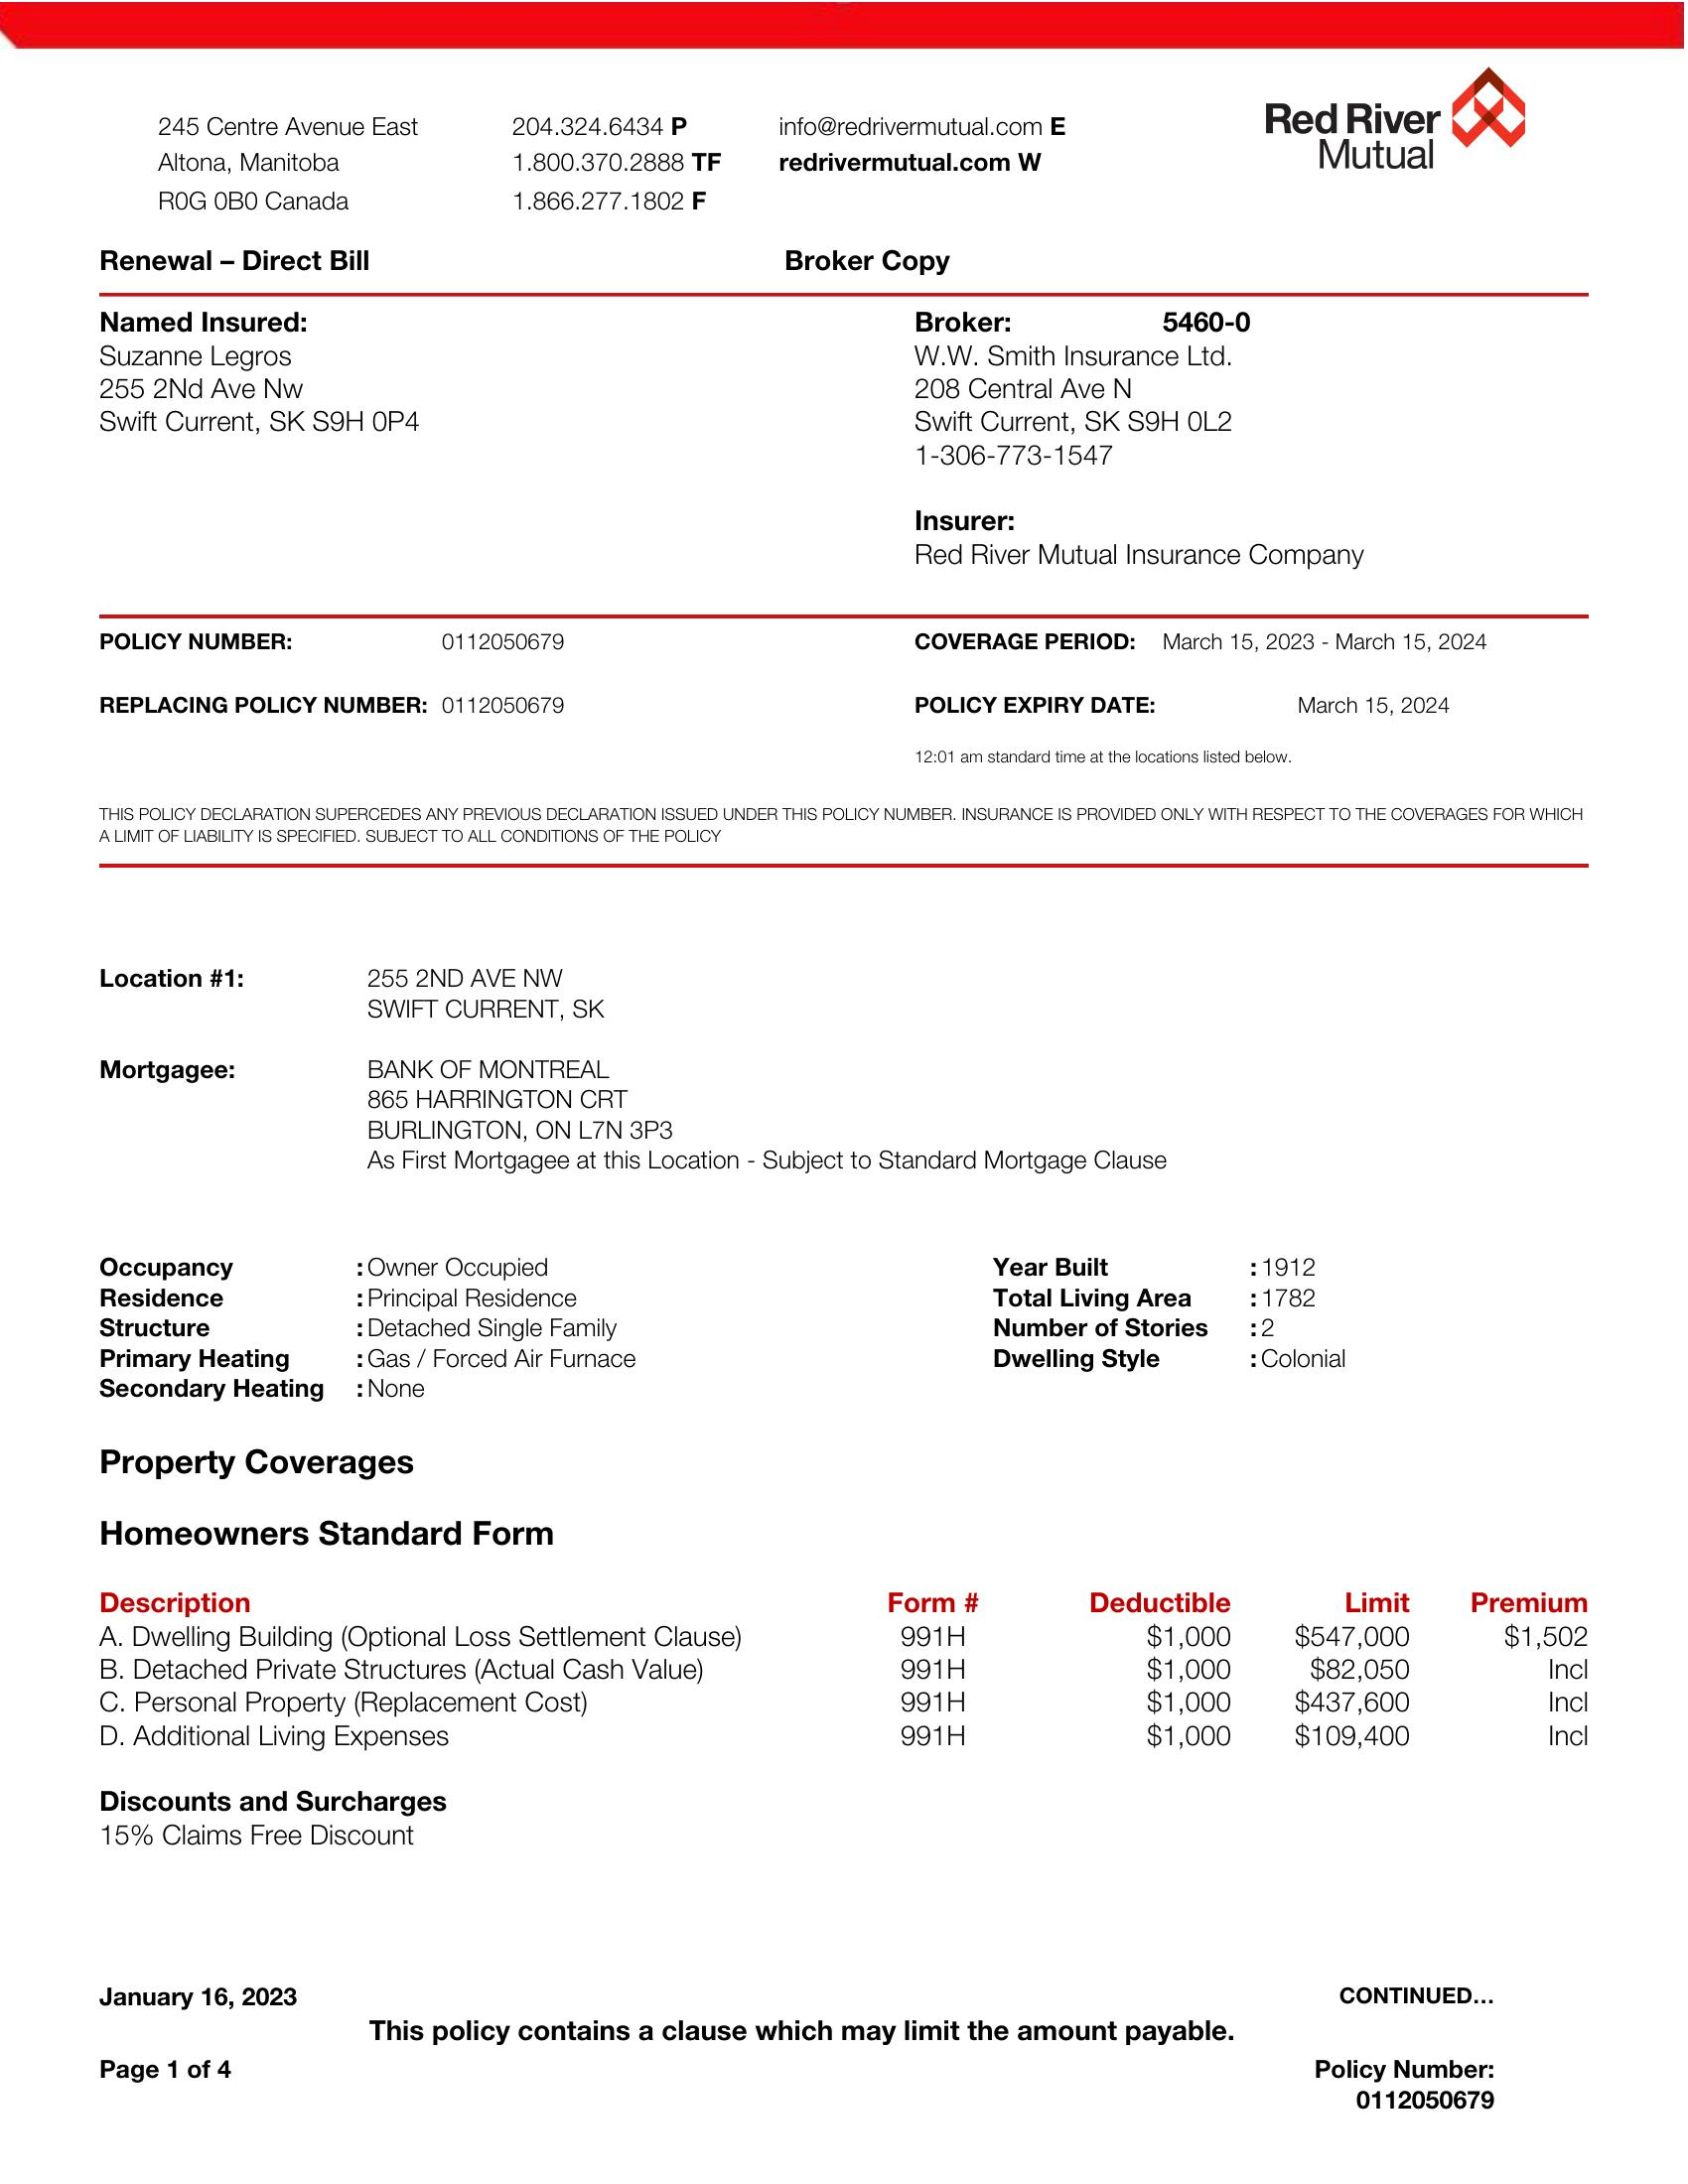

In [111]:
inference_dataset[0]['image']